In [1]:
## 데이터 > 트레인 >= 테스트
## data >  train  >=  test
## 데이터에서 test를 제외한 나머지로 train

In [2]:
pip install --user pmdarima

In [3]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from pmdarima.arima import auto_arima
from pmdarima.arima import ndiffs

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
data = pd.read_csv('data/electricity.csv')
data

,Residential,Commercial,Industrial,Total,dates
0,3078100.0,2016100.0,2425400.0,7770200.0,1990-01-01
1,2660700.0,2032600.0,2664500.0,7620100.0,1990-02-01
2,2319400.0,1870300.0,2478800.0,6905400.0,1990-03-01
3,2173000.0,1882700.0,2541300.0,6835700.0,1990-04-01
4,2028400.0,1901300.0,2540600.0,6714600.0,1990-05-01
...,...,...,...,...,...
310,3079400.0,3464700.0,2545900.0,9110300.0,2015-11-01
311,3581700.0,3429430.0,2449100.0,9480300.0,2015-12-01
312,4219200.0,3559200.0,2460900.0,10260000.0,2016-01-01
313,3997000.0,3563400.0,2561800.0,10145000.0,2016-02-01


In [5]:
df = data[['dates','Total']]

df = df.rename(columns = {
    'Total':'total'
})

df['dates'] = pd.to_datetime(df['dates'])

df['year'] = df['dates'].dt.year

df9703 = df.query('year >= 1997 & year <= 2003')

df9703 = df9703.set_index('dates', drop=True)

df9703 = df9703[['total']]

In [6]:
# df9703 = df9703.set_index('dates', drop=True)

In [7]:
print('< Input >')
print(df9703) #데이터 확인

< Input >
                 total
dates                 
1997-01-01   8882200.0
1997-02-01   8959500.0
1997-03-01   7854700.0
1997-04-01   7826900.0
1997-05-01   7636900.0
...                ...
2003-08-01  11026000.0
2003-09-01  10220000.0
2003-10-01   8947700.0
2003-11-01   8765900.0
2003-12-01   9478600.0

[84 rows x 1 columns]


In [8]:
me = df9703.copy(deep=True) # 데이터 깊은 복사

In [9]:
# '''
split = int(rate*len(me)) #7:3 비율

train = me[:split] #학습
test = me[split:] #예측

print('train len :', len(train), ', test len :', len(test))
# '''

train len : 58 , test len : 26


In [10]:
## adf 검정 ; pvalue 확인 함수
def adf_test(train):
    stat, p_value, lags, nobs, crit, icb = adfuller(train)
    return p_value

In [11]:
p_v = adf_test(train = train)
print('.....original pvalue :', p_v)

.....original pvalue : 0.5441961750948482


In [12]:
## 정상성 확인 및 변환 함수
def stationary(train):
    
    if p_v > 0.05:
        kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
        adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
        d = max(adf_diffs, kpss_diffs)

        print('.....n_diffs :', d)

        if d>0:

            diff_train = train.diff(d) #차분

            diff_train = diff_train.dropna(axis=0) #공백제거

            diff_p_v = adf_test(diff_train) #다시 pval 확인
            print('.....diff p_value :', diff_p_v) #대부분 여기서 0.05 이하로 나오지 않을까

            if diff_p_v > 0.05: #분산 일정x 경우
                log_train = np.log(diff_train) #로그 변환
                # 경고해결방법..
                # RuntimeWarning: invalid value encountered in log result = func(self.values, **kwargs)
                #

                log_train = log_train.dropna(axis=0) #공백제거

                log_p_v = adf_test(log_train) #다시 pval 확인
                print('.....log p_value :', log_p_v) 

             

                if ((log_p_v) > 0.05): #이건
                    print('EXIT')
                    exit()
                else:
                    print('.....final p_value :', log_p_v)
                    
                    print('< Stationary Train data >')
                    plt.plot(log_train)
                    plt.show()                      
                    
                    return [d, log_train]
                
            else:
                return [d, diff_train]
    
    print('Already Stationary data')
    return [d, train]

.....n_diffs : 1
.....diff p_value : 0.07021480968137404
.....log p_value : 0.03904550427976579
.....final p_value : 0.03904550427976579
< Stationary Train data >


C:\Users\mirae\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


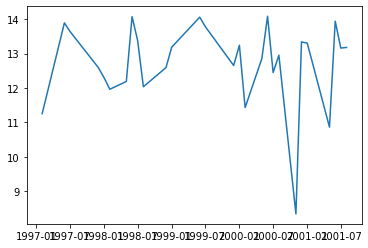

In [13]:
diff, st_train = stationary(train = train) #차분 횟수와 정상화된 데이터 저장
# 경고해결방법 찾기
# RuntimeWarning: invalid value encountered in log

In [14]:
## 최적 모델 찾기

def autoarima(train, diff, m52):

    m_list = [1, 7, 12] #계절성 주기
    if m52 == 'o':
        m_list.append(52)
    
    model = None #모델
    aic = 99999 #AIC
    cycle = 1 #계절성 주기
    
    for m_test in m_list: #52까지 하면 웹꺼짐..
        arima = auto_arima(
                y = train, #####이름 수정
                d = diff, #차분 횟수
                m = m_test, 
                seasonal = True, 
                trace = True
                )
        if arima.aic() < aic:
            aic = arima.aic()
            model = arima
            cycle = m_test
            
    return [cycle, model]

In [15]:
print('< AutoArima >')
cycle, model = autoarima(
                train = train, ####이름 수정
                diff = diff,
                m52 = m52
               ) #계절성 주기와 모델 저장

< AutoArima >
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1694.981, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1695.041, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1693.903, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1692.992, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1698.275, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.789 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=1640.732, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1694.981, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1695.621, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1694.456, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1692.992, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC

In [16]:
print('< Auto Arima Model >', model, sep = '\n')

< Auto Arima Model >
 ARIMA(0,1,2)(1,1,0)[12]          


SARIMAX

https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b

In [17]:
if cycle == 1:
    
    arima = ARIMA(train, order = model.order)
    
else:
    
    arima = SARIMAX(train, order = model.order, seasonal_order = model.seasonal_order)
    
# 경고해결방법
# ValueWarning: No frequency information was provided, so inferred frequency MS will be used.



C:\Users\mirae\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mirae\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [18]:
arima_fit = arima.fit()
print('< ARIMA fit summary >')
print(arima_fit.summary())

< ARIMA fit summary >
                                      SARIMAX Results                                      
Dep. Variable:                               total   No. Observations:                   58
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 12)   Log Likelihood                -621.103
Date:                             Wed, 08 Feb 2023   AIC                           1250.206
Time:                                     00:06:19   BIC                           1257.433
Sample:                                 01-01-1997   HQIC                          1252.900
                                      - 10-01-2001                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0142      0.151     -0.094      0.925      -0.311       0.282
ma.L2

< Diagnostic plots for standardized residuals >
Figure(1152x648)


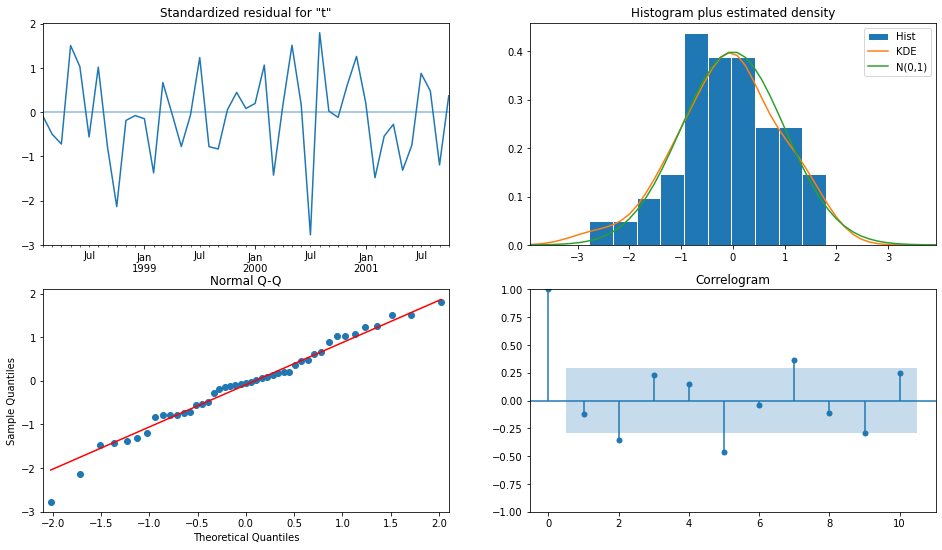

In [19]:
print('< Diagnostic plots for standardized residuals >')
print(arima_fit.plot_diagnostics(figsize = (16,9)))

In [20]:
## 평가

future_forecast = arima_fit.predict(
                        start = test.index[0],
                        end = test.index[-1],
                        typ='levels'
                  )

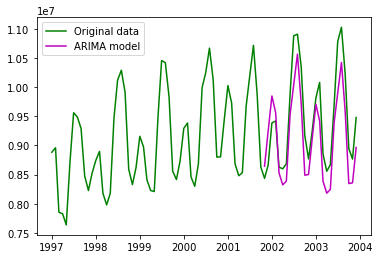

In [21]:
plt.plot(me, label='Original data', color='g')
plt.plot(future_forecast, label='ARIMA model', color='m')

plt.legend()
plt.show()

In [ ]:
def arima_fn(data, rate, m52):
    
    return None

In [22]:
arima_fn(
    data = data, 
    rate = rate,
    m52 = m52
) #시작
# arima_fn(답이 있는 예측할 데이터, train/test 비율, autoarima에서 m=52도 실행하는지)

NameError: name 'arima_fn' is not defined